# Imports

In [1]:
#!/usr/bin/env python3

import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.cluster import KMeans
from time import time
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
from pylab import rcParams
import pickle
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D

# Data Load

In [2]:
df = pd.read_csv('DG_out.csv', sep=',')
df.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.0,50.0,50.0,0.0,50.0,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.0,50.0,100.0,50.0,25.0,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.0,10.0,20.0,10.0,10.0,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.0,30.0,70.0,40.0,30.0,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.0,30.0,60.0,30.0,15.0,0,0,0,0,0


In [3]:
df.drop('tx_hash', axis=1, inplace=True)
df.drop('in_malicious', axis=1, inplace=True)
df.drop('out_malicious', axis=1, inplace=True)
df.drop('is_malicious', axis=1, inplace=True)
df.drop('all_malicious', axis=1, inplace=True)
df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,2.148699e+00,2.148699e+00,5.484150e+01,5.484150e+01,1.096830e+02,4.923980e+01,2.877087e+01,3.570468e-06
std,7.421447e+00,4.512048e+00,1.303303e+03,1.301473e+03,2.602527e+03,9.729210e+02,7.125567e+02,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e-01,9.950000e-02,2.058720e-01,6.400000e-02,5.025776e-02,0.000000e+00
50%,1.000000e+00,2.000000e+00,9.325000e-01,9.590000e-01,1.964759e+00,5.350261e-01,4.900000e-01,0.000000e+00
75%,2.000000e+00,2.000000e+00,8.591912e+00,9.063657e+00,1.840000e+01,5.614287e+00,4.519481e+00,0.000000e+00
max,1.932000e+03,1.322000e+03,5.500000e+05,5.000207e+05,1.050000e+06,4.992596e+05,5.000000e+05,1.000000e+00


In [4]:
# The classes are heavily skewed.
print('No Frauds', round(df['out_and_tx_malicious'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['out_and_tx_malicious'].value_counts()[1]/len(df) * 100,5), '% of the dataset')

No Frauds 100.0 % of the dataset
Frauds 0.00036 % of the dataset


In [5]:
df['out_and_tx_malicious'].value_counts()

out_and_tx_malicious
0    30248026
1         108
Name: count, dtype: int64

# Scale transform

In [6]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

# Split

In [7]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(scaled_df.iloc[:,:-1], scaled_df['out_and_tx_malicious'], test_size = 0.20, random_state=10)

In [8]:
pd.value_counts(original_ytrain)

/tmp/ipykernel_1287/1412996729.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(original_ytrain)


out_and_tx_malicious
0    24198425
1          82
Name: count, dtype: int64

In [9]:
pd.value_counts(original_ytest)

/tmp/ipykernel_1287/2604460319.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(original_ytest)


out_and_tx_malicious
0    6049601
1         26
Name: count, dtype: int64

In [10]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


# Oversampling Training Data

In [11]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SMOT = SMOTE(fraction, n_jobs=-1)
    return SMOT.fit_resample(X, y)

# Modeling

In [12]:
models = {}
sse = {}
calinski_harabaz = {}

for k in range(2, 13):
    kmeans = MiniBatchKMeans(init='k-means++', n_clusters=k, n_init=1000, max_iter=15000, batch_size=256)
    kmeans.fit(original_Xtrain)    
    models[k] = kmeans    
    labels = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    print("\nDone with k = "+str(k))
#     calinski_harabaz[k] = metrics.calinski_harabaz_score(resampled_train_x, labels)
#     print("Calinski harabaz score computation done!")




Done with k = 2

Done with k = 3

Done with k = 4

Done with k = 5

Done with k = 6

Done with k = 7

Done with k = 8

Done with k = 9

Done with k = 10

Done with k = 11

Done with k = 12


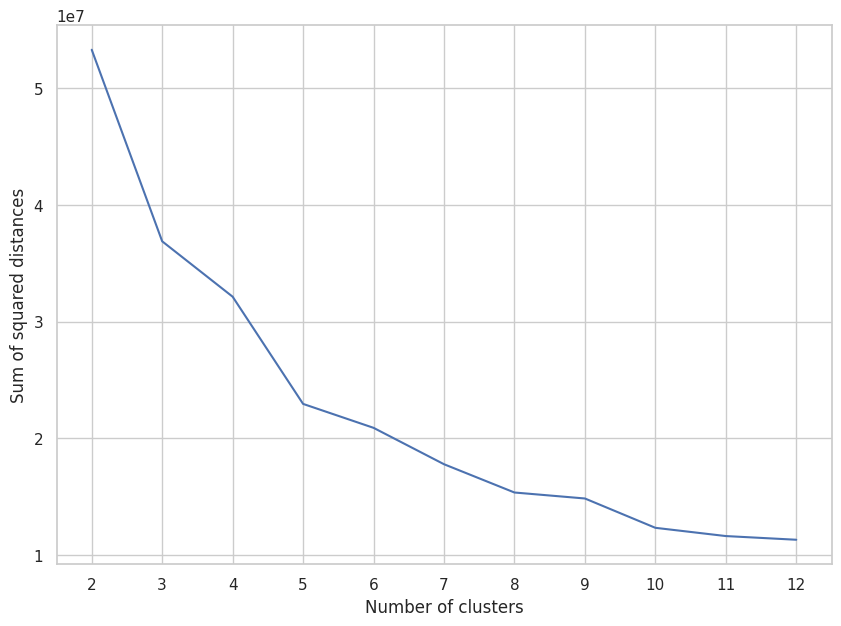

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use Seaborn style
sns.set(style='whitegrid')

# Your plotting code here
plt.figure(figsize=(10,7))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xticks(list(sse.keys()))
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.show()



# Save Model

In [14]:
import os
import pickle

# Check if the directory exists, if not, create it
directory = './Models/Kmeans/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Iterate over models and save them
for k in models:
    with open(directory + 'k=' + str(k) + '.h5', 'wb') as file:
        pickle.dump(models.get(k), file)


In [15]:
for k in models:
    pickle.dump(models.get(k), open('./Models/Kmeans/k='+str(k)+'.h5', 'wb'))

# Tabular Train Data Evaluation

In [16]:
##code for k kluster executions:

train_predictions = {}
normal_count_train = pd.value_counts(original_ytrain)[0]
fraud_count_train = pd.value_counts(original_ytrain)[1]

for k in models:
    print('Model with K='+str(k)+'\n'+'=================================\n')
    train_predictions[k] = models.get(k).predict(original_Xtrain)
    print("Predicted for K="+str(k))
    loc = 0
    count_dict = {}
    fraud_indices = set(np.where(original_ytrain == 1)[0])
    
    for pred in train_predictions[k]:
        count_dict[pred] = count_dict.get(pred, 0)
        if loc in fraud_indices:
            count_dict[pred] += 1
        loc += 1
    
    for key, value in sorted(count_dict.items()):
        non_fraud = len((np.where(train_predictions[k] == key)[0])) - value
        print('Cluster '+str(key+1)+': \t Fraudulent: '+str(value)+ ' ('+str(round((value*100)/fraud_count_train,3))+'%)' +
              ' \t Non-Fraudulent: '+str(non_fraud)+' ('+str(round((non_fraud*100)/normal_count_train,3))+'%)\n')
    print('\n')


/tmp/ipykernel_1287/2139381004.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  normal_count_train = pd.value_counts(original_ytrain)[0]
/tmp/ipykernel_1287/2139381004.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fraud_count_train = pd.value_counts(original_ytrain)[1]


Model with K=2

Predicted for K=2
Cluster 1: 	 Fraudulent: 68 (82.927%) 	 Non-Fraudulent: 6547018 (27.056%)

Cluster 2: 	 Fraudulent: 14 (17.073%) 	 Non-Fraudulent: 17651407 (72.944%)



Model with K=3

Predicted for K=3
Cluster 1: 	 Fraudulent: 56 (68.293%) 	 Non-Fraudulent: 6157655 (25.447%)

Cluster 2: 	 Fraudulent: 6 (7.317%) 	 Non-Fraudulent: 14560557 (60.172%)

Cluster 3: 	 Fraudulent: 20 (24.39%) 	 Non-Fraudulent: 3480213 (14.382%)



Model with K=4

Predicted for K=4
Cluster 1: 	 Fraudulent: 51 (62.195%) 	 Non-Fraudulent: 5893305 (24.354%)

Cluster 2: 	 Fraudulent: 11 (13.415%) 	 Non-Fraudulent: 5475039 (22.626%)

Cluster 3: 	 Fraudulent: 4 (4.878%) 	 Non-Fraudulent: 12086569 (49.948%)

Cluster 4: 	 Fraudulent: 16 (19.512%) 	 Non-Fraudulent: 743512 (3.073%)



Model with K=5

Predicted for K=5
Cluster 1: 	 Fraudulent: 10 (12.195%) 	 Non-Fraudulent: 6192634 (25.591%)

Cluster 2: 	 Fraudulent: 49 (59.756%) 	 Non-Fraudulent: 2272741 (9.392%)

Cluster 3: 	 Fraudulent: 1 (1.22%) 	 N

# Tabular Test Data Evaluation

In [17]:
## Code for Tabular Data Evaluations for test Dataset.

predictions = {}
normal_count_test = pd.value_counts(original_ytest)[0]
fraud_count_test = pd.value_counts(original_ytest)[1]

for k in models:
    print('Model with K='+str(k)+'\n'+'=================================\n')
    predictions[k] = models.get(k).predict(original_Xtest)
    print("Predicted for K="+str(k))
    loc = 0
    count_dict = {}
    fraud_indices = set(np.where(original_ytest == 1)[0])
    
    for pred in predictions[k]:
        count_dict[pred] = count_dict.get(pred, 0)
        if loc in fraud_indices:
            count_dict[pred] += 1
        loc += 1
    
    for key, value in sorted(count_dict.items()):
        non_fraud = len((np.where(predictions[k] == key)[0])) - value
        print('Cluster '+str(key+1)+': \t Fraudulent: '+str(value)+ ' ('+str(round((value*100)/fraud_count_test,3))+'%)' +
              ' \t Non-Fraudulent: '+str(non_fraud)+' ('+str(round((non_fraud*100)/normal_count_test,3))+'%)\n')
    print('\n')


Model with K=2



/tmp/ipykernel_1287/1912683294.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  normal_count_test = pd.value_counts(original_ytest)[0]
/tmp/ipykernel_1287/1912683294.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fraud_count_test = pd.value_counts(original_ytest)[1]


Predicted for K=2
Cluster 1: 	 Fraudulent: 23 (88.462%) 	 Non-Fraudulent: 1635869 (27.041%)

Cluster 2: 	 Fraudulent: 3 (11.538%) 	 Non-Fraudulent: 4413732 (72.959%)



Model with K=3

Predicted for K=3
Cluster 1: 	 Fraudulent: 19 (73.077%) 	 Non-Fraudulent: 1538240 (25.427%)

Cluster 2: 	 Fraudulent: 2 (7.692%) 	 Non-Fraudulent: 3640495 (60.177%)

Cluster 3: 	 Fraudulent: 5 (19.231%) 	 Non-Fraudulent: 870866 (14.395%)



Model with K=4

Predicted for K=4
Cluster 1: 	 Fraudulent: 17 (65.385%) 	 Non-Fraudulent: 1472020 (24.333%)

Cluster 2: 	 Fraudulent: 0 (0.0%) 	 Non-Fraudulent: 1369761 (22.642%)

Cluster 3: 	 Fraudulent: 2 (7.692%) 	 Non-Fraudulent: 3021636 (49.948%)

Cluster 4: 	 Fraudulent: 7 (26.923%) 	 Non-Fraudulent: 186184 (3.078%)



Model with K=5

Predicted for K=5
Cluster 1: 	 Fraudulent: 0 (0.0%) 	 Non-Fraudulent: 1548448 (25.596%)

Cluster 2: 	 Fraudulent: 15 (57.692%) 	 Non-Fraudulent: 567168 (9.375%)

Cluster 3: 	 Fraudulent: 1 (3.846%) 	 Non-Fraudulent: 2371852 (39.207

# Tag predictions to cluster test dataset

In [20]:
# Tag predictions for predicting to cluster the test dataset.
k = 5
cluster_df = original_Xtest.copy()

#Tag Anomalies
anomaly_tag = []
loc = 0
m_locs = np.where(original_ytest == 1)[0]
for pred in predictions[k]:
    if loc in m_locs:
        anomaly_tag.append(1)
    else:
        anomaly_tag.append(0)
    loc = loc + 1
    
#Plot Clusters
cluster_df['cluster'] = predictions[k]
cluster_df['is_anomaly'] = anomaly_tag
cluster_df_plot = cluster_df.copy()
#cluster_df_plot = cluster_df.sample(1000000)

cluster_df_plot.head()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,cluster,is_anomaly
1695537,0.000000,0.0,1.034805,1.006003,0.892075,1.352483,1.121863,3,0
12936982,0.000000,0.0,-0.093141,-0.097396,-0.114246,0.015631,-0.087101,2,0
12619145,0.000000,0.0,-0.209808,-0.211551,-0.256661,-0.122644,-0.175717,2,0
24618801,1.709511,0.0,-0.190014,-0.192182,-0.230979,-0.185605,-0.161344,0,0
638748,0.000000,0.0,2.059548,2.008314,1.699867,2.567017,2.430639,1,0


# Reduce Dimensions for Visualization

In [21]:
comp = 3
pca = PCA(n_components=comp)
trimmed_cluster_df_plot = cluster_df_plot.iloc[:,0:5]
pca.fit(trimmed_cluster_df_plot)
trimmed_cluster_df_plot.head()

,indegree,outdegree,in_btc,out_btc,total_btc
1695537,0.000000,0.0,1.034805,1.006003,0.892075
12936982,0.000000,0.0,-0.093141,-0.097396,-0.114246
12619145,0.000000,0.0,-0.209808,-0.211551,-0.256661
24618801,1.709511,0.0,-0.190014,-0.192182,-0.230979
638748,0.000000,0.0,2.059548,2.008314,1.699867


In [23]:
comp = 3
pca = PCA(n_components=comp)
trimmed_cluster_df_plot = cluster_df_plot.iloc[:, :5]  # Assuming you want to keep the first 5 columns
pca.fit(trimmed_cluster_df_plot)
trimmed_cluster_df_plot.head()


,indegree,outdegree,in_btc,out_btc,total_btc
1695537,0.000000,0.0,1.034805,1.006003,0.892075
12936982,0.000000,0.0,-0.093141,-0.097396,-0.114246
12619145,0.000000,0.0,-0.209808,-0.211551,-0.256661
24618801,1.709511,0.0,-0.190014,-0.192182,-0.230979
638748,0.000000,0.0,2.059548,2.008314,1.699867


In [24]:
columns = ['pca_%i' % i for i in range(comp)]
df_pca = pd.DataFrame(pca.transform(trimmed_cluster_df_plot), columns=columns, index=trimmed_cluster_df_plot.index)
df_pca['cluster'] = cluster_df_plot['cluster']
df_pca['is_anomaly'] = cluster_df_plot['is_anomaly']
df_pca.head()


,pca_0,pca_1,pca_2,cluster,is_anomaly
1695537,1.323969,-0.271829,0.008047,3,0
12936982,-0.480158,-0.768105,0.043250,2,0
12619145,-0.686660,-0.824788,0.047724,2,0
24618801,-1.104270,0.832894,0.034143,0,0
638748,2.907733,0.164170,-0.021621,1,0


# 2D Clusters Plot

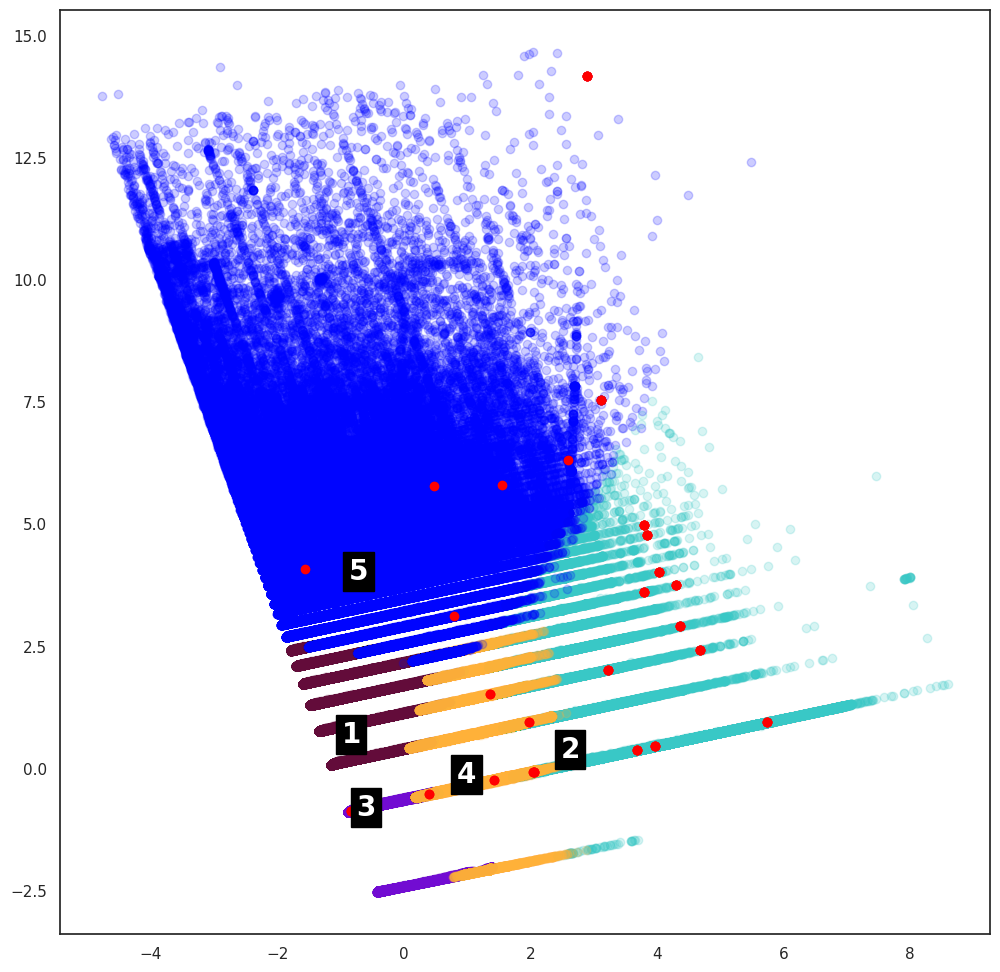

In [25]:
# Set font size of labels on matplotlib plots
plt.rc('font', size=16)

# Set style of plots
sns.set_style('white')

# Define a custom palette
custom_palette = ['#630C3A', '#39C8C6', '#720cd2', '#FFB139', '#0004FF', '#04FF00', '#00C3FF', '#FFD800', '#00F3FF', '#7000FF', '#00B2FF']
sns.set_palette(custom_palette)

# Define groups
groups = {}
for i in range(0, k):
    groups[i] = i

# Create a new figure
plt.figure(figsize=(12,12))

# Loop through labels and plot each cluster
for i, label in enumerate(groups.keys()):
    # Add data points 
    plt.scatter(x=df_pca.loc[df_pca['cluster']==label, 'pca_0'], 
                y=df_pca.loc[df_pca['cluster']==label,'pca_1'], 
                color=custom_palette[i], 
                alpha=0.20)
    # Add label
    plt.annotate((int(label)+1), 
                 df_pca.loc[df_pca['cluster']==label,['pca_0','pca_1']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='white',
                 backgroundcolor='#000000') 
    
    # Mark anomalies
    plt.scatter(x=df_pca.loc[df_pca['is_anomaly']==1, 'pca_0'], 
                y=df_pca.loc[df_pca['is_anomaly']==1,'pca_1'], 
                color='#FF0000', 
                alpha=1)


# 3D Clusters Plot

In [ ]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

x = df_pca['pca_0']
y = df_pca['pca_1']
z = df_pca['pca_2']

ax.scatter(x, y, z, c=df_pca['cluster'], marker='o', cmap="viridis", alpha=0.1)

for i, label in enumerate(groups.keys()):
    cx = df_pca[df_pca['cluster'] == label][['pca_0', 'pca_1', 'pca_2']].mean()[0]
    cy = df_pca[df_pca['cluster'] == label][['pca_0', 'pca_1', 'pca_2']].mean()[1]
    cz = df_pca[df_pca['cluster'] == label][['pca_0', 'pca_1', 'pca_2']].mean()[2]
    ax.text(cx, cy, cz, '%s' % (str(label+1)), size=15, horizontalalignment='center',
             verticalalignment='center', weight='bold', color='white', backgroundcolor='#000000') 

ax.plot(df_pca[df_pca['is_anomaly']==1]['pca_0'], 
        df_pca[df_pca['is_anomaly']==1]['pca_1'], 
        df_pca[df_pca['is_anomaly']==1]['pca_2'], 
        'D', markersize=4, c='r')

ax.set_xlabel('\n\nPCA-1')
ax.set_ylabel('\n\nPCA-2')
ax.set_zlabel('\n\nPCA-3')

plt.show()


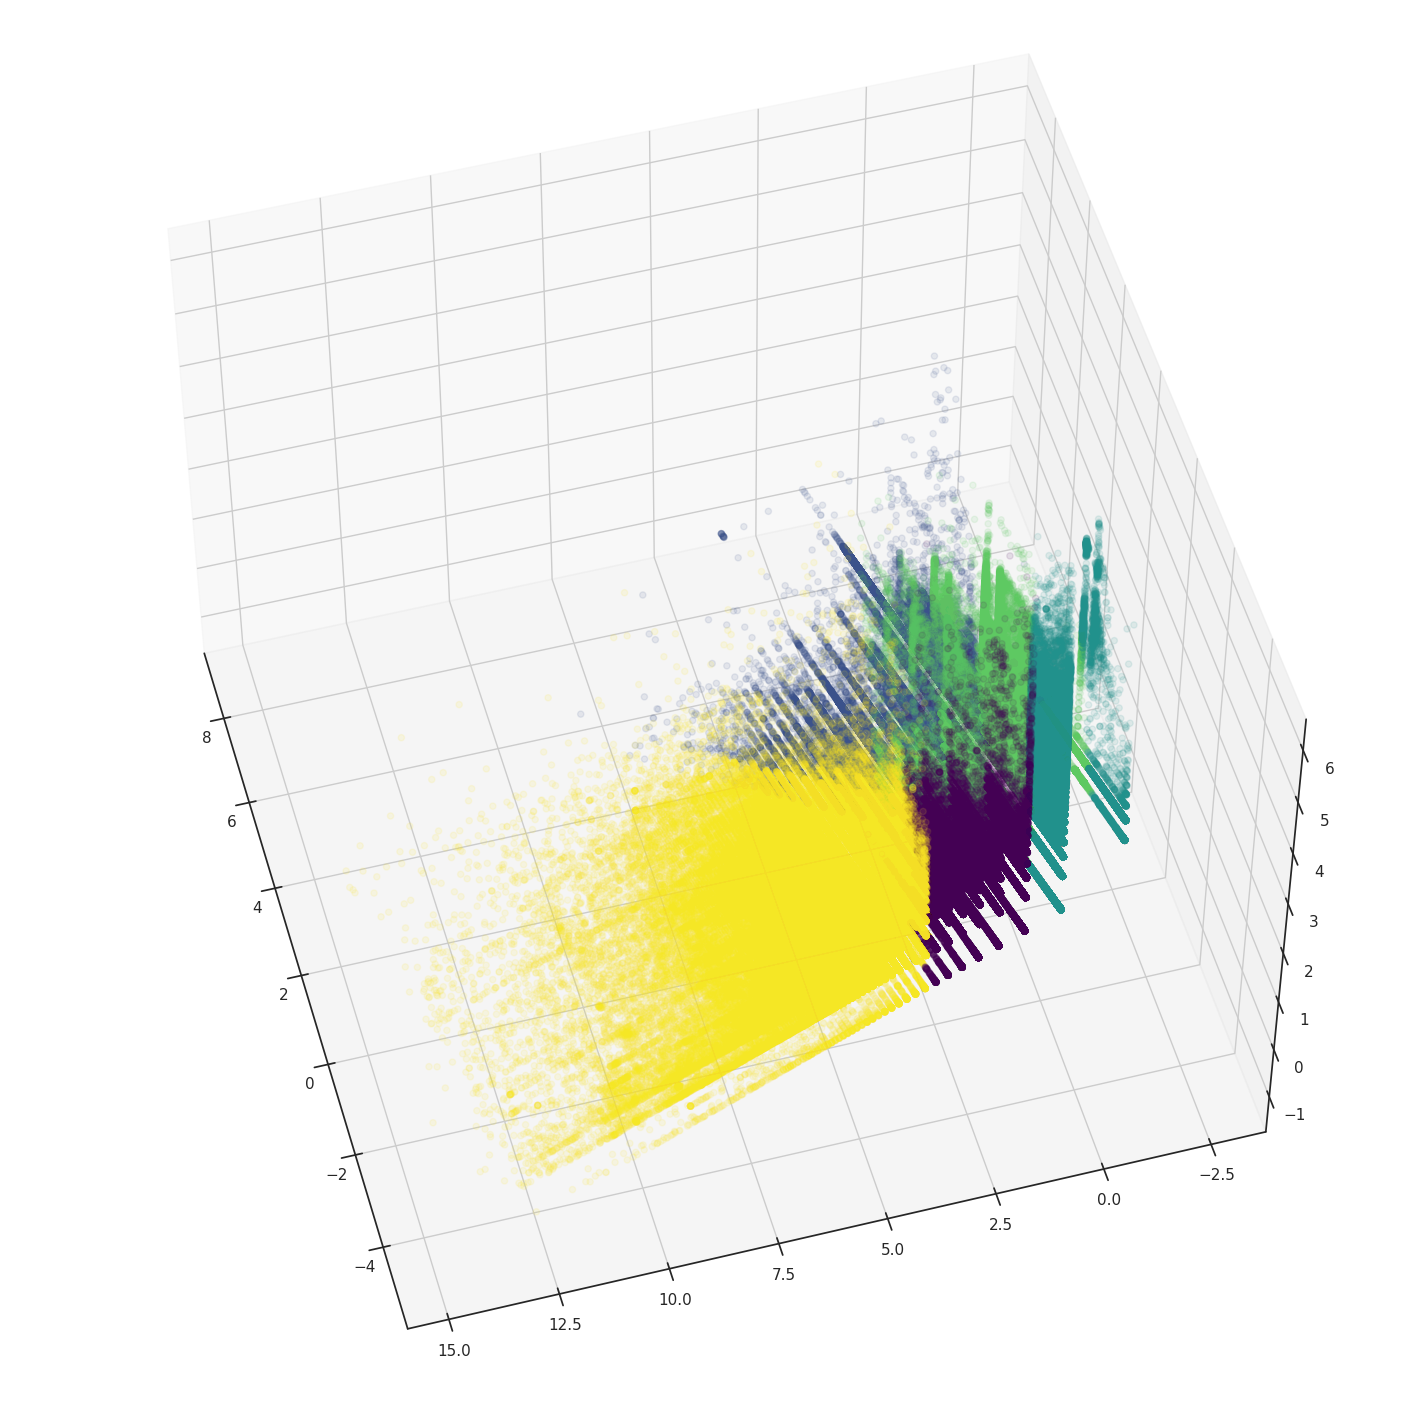

In [29]:
ax.view_init(51.25, 164.5)
fig

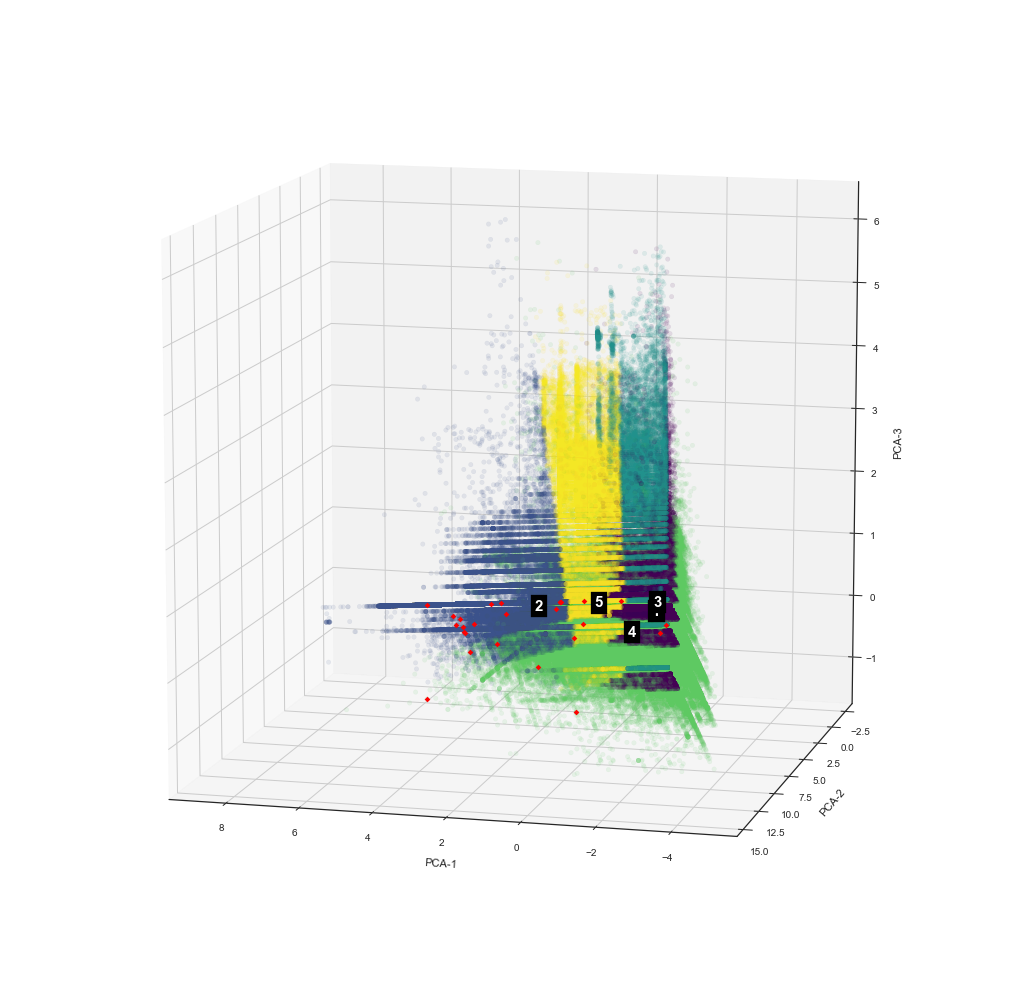

In [28]:
ax.view_init(11.25, 104.5)
fig

# Evaluation Util

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

def evaluation_summary(test_y, predictions, clf_name):
    print('For ' + clf_name)
    print('Balanced Accuracy: '+ str(round(balanced_accuracy_score(test_y, predictions),7)))
    print('Macro Precision: '+ str(round(precision_score(test_y, predictions, average="macro"),7)))
    print('Macro Recall: '+ str(round(recall_score(test_y,predictions, average="macro"),7)))
    print('Macro F1: '+ str(round(f1_score(test_y,predictions, average="macro"),7)))
    print('\n')
    
    print('Normal Accuracy: '+ str(round(accuracy_score(test_y, predictions),7)))
    print('Normal Precision: '+ str(round(precision_score(test_y, predictions),7)))
    print('Normal Recall: '+ str(round(recall_score(test_y,predictions),7)))
    print('Normal F1: '+ str(round(f1_score(test_y,predictions),7)))
    print('\n')
    print(classification_report(test_y, predictions, labels=[0, 1]))
    print('\n')

In [31]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual
    conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Training Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title("Test Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

In [32]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
#     conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 12}, fmt="d", ax=ax1);
    ax1.set_title("Training Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
#     conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 12}, fmt="d", ax=ax2);
    ax2.set_title("Test Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

# Train Cluster Merge

In [33]:
print('For K='+str(k))
merge = [4,2]

prediction = predictions[k].copy()
t_prediction = train_predictions[k].copy()


if len(pd.value_counts(t_prediction)) > 2 and len(pd.value_counts(prediction)) > 2:
    for i in range(0,k):
        if (i+1) in merge:
            prediction[prediction == i] = -1
            t_prediction[t_prediction == i] = -1
        else:
            prediction[prediction == i] = 0
            t_prediction[t_prediction == i] = 0

    prediction[prediction == -1] = 1
    t_prediction[t_prediction == -1] = 1

    print('Train Cluster Merge Result:\n')
    print(pd.value_counts(t_prediction))

    print('\n\nTest Cluster Merge Result:\n')
    print(pd.value_counts(prediction))

For K=5


/tmp/ipykernel_1287/23083620.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  if len(pd.value_counts(t_prediction)) > 2 and len(pd.value_counts(prediction)) > 2:


Train Cluster Merge Result:

0    16465269
1     7733238
Name: count, dtype: int64


Test Cluster Merge Result:

0    4117870
1    1931757
Name: count, dtype: int64


/tmp/ipykernel_1287/23083620.py:21: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(t_prediction))
/tmp/ipykernel_1287/23083620.py:24: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(prediction))


# Training Evaluation

In [34]:
evaluation_summary(original_ytrain, t_prediction, 'K-means (K='+str(k)+')')

For K-means (K=5)
Balanced Accuracy: 0.6877741
Macro Precision: 0.5000029
Macro Recall: 0.6877741
Macro F1: 0.40492


Normal Accuracy: 0.6804263
Normal Precision: 7.4e-06
Normal Recall: 0.695122
Normal F1: 1.47e-05


              precision    recall  f1-score   support

           0       1.00      0.68      0.81  24198425
           1       0.00      0.70      0.00        82

    accuracy                           0.68  24198507
   macro avg       0.50      0.69      0.40  24198507
weighted avg       1.00      0.68      0.81  24198507





# Test Evaluation

In [35]:
evaluation_summary(original_ytest, prediction, 'K-means (K='+str(k)+')')

For K-means (K=5)
Balanced Accuracy: 0.6864955
Macro Precision: 0.5000037
Macro Recall: 0.6864955
Macro F1: 0.4050129


Normal Accuracy: 0.6806833
Normal Precision: 9.3e-06
Normal Recall: 0.6923077
Normal F1: 1.86e-05


              precision    recall  f1-score   support

           0       1.00      0.68      0.81   6049601
           1       0.00      0.69      0.00        26

    accuracy                           0.68   6049627
   macro avg       0.50      0.69      0.41   6049627
weighted avg       1.00      0.68      0.81   6049627





# Confusion Matrices

In [36]:
cnf_mtx_test = confusion_matrix(original_ytest, prediction)
cnf_mtx_train = confusion_matrix(original_ytrain, t_prediction)

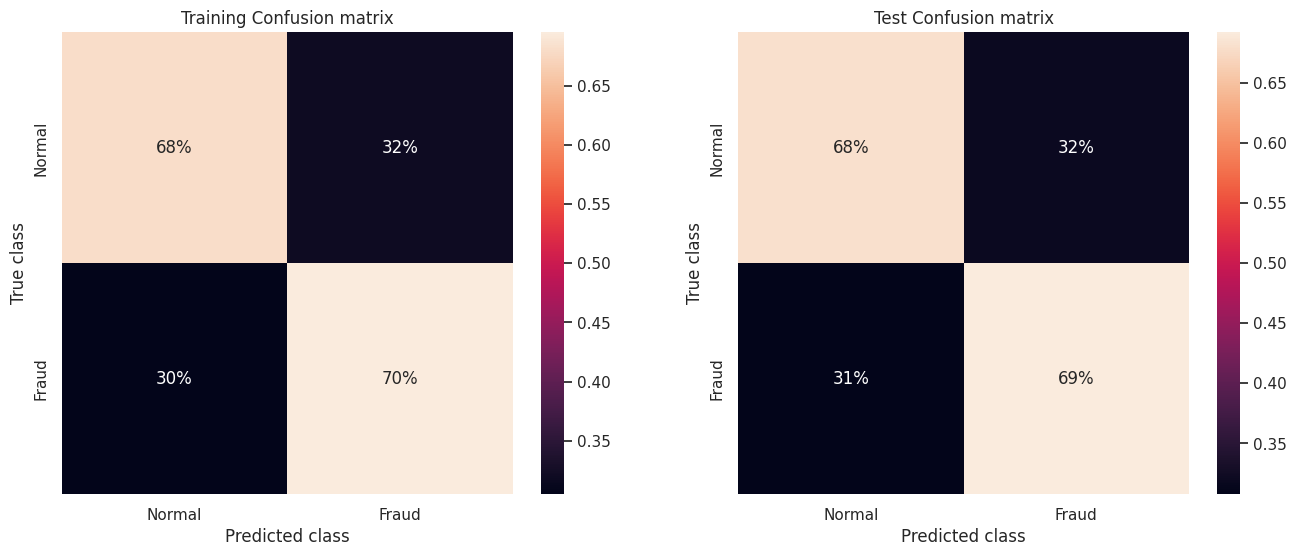

In [37]:
conf_matrix_percent(cnf_mtx_train, cnf_mtx_test)

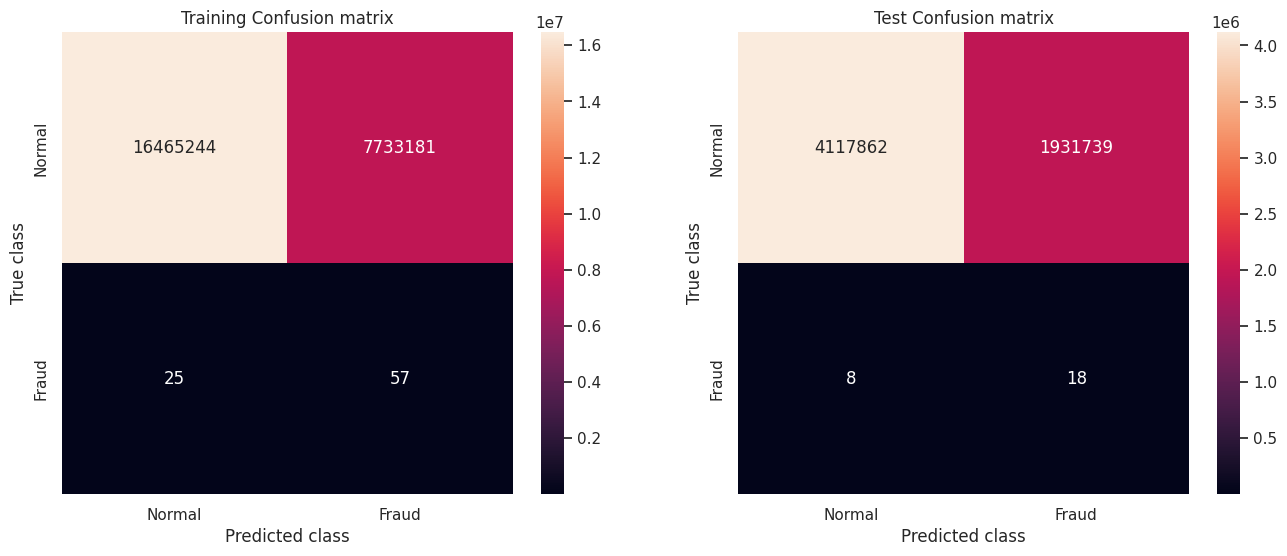

In [38]:
conf_matrix_normal(cnf_mtx_train, cnf_mtx_test)